<a href="https://colab.research.google.com/github/fidelis2025/stankelly-website/blob/main/Lawrence_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Step 1: Upload file manually
from google.colab import files
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

uploaded = files.upload()  # This lets you pick file from your PC
file_path = list(uploaded.keys())[0]  # Automatically use uploaded filename

# Step 2: Read dataset
data = pd.read_excel(file_path) # Changed read_csv to read_excel
print("Original Data (first 5 rows):")
print(data.head())

Saving UDHS_Awareness_Youth.xlsx to UDHS_Awareness_Youth (2).xlsx
Original Data (first 5 rows):
  Background_characteristic     Sex  Condom_knowledge  \
0                 Age_group     NaN               NaN   
1                    15 -19  Female              78.5   
2                     15-19    Male              86.7   
3                    20 -24  Female              87.6   
4                     20-24    Male              90.7   

   Partner_limitation_knowledge   Combined_prevention_knowledge  Sample_size  
0                            NaN                            NaN          NaN  
1                           83.7                           72.5       3936.0  
2                           86.0                           78.9       1277.0  
3                           91.6                           83.5       3506.0  
4                           93.1                           86.8        896.0  


In [10]:
!pip install numpy pandas matplotlib scipy scikit-learn

/tmp/ipython-input-2234278769.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  youth_data["awareness_index"] = youth_data["Combined_prevention_knowledge"] / 100


Average awareness index A_bar: 0.804


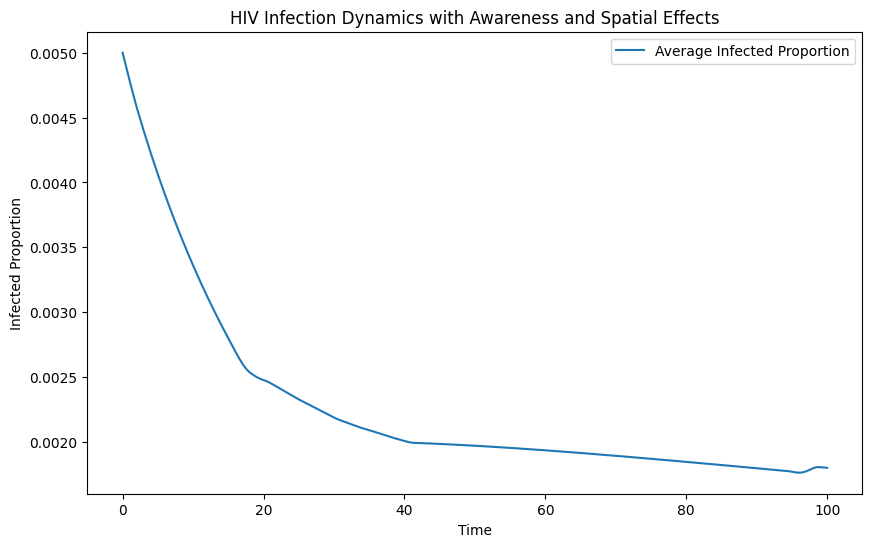

Validation Metrics:
RMSE: 0.1077, MAPE: 97.93%, MAD: 0.1077, R: -6695429452153998913141720743936.0000
Sensitivity analysis:
    beta0  gamma0  tau  rho  peak_infection
0     0.4     0.1    3  0.1        0.027142
1     0.4     0.1    3  0.2        0.107487
2     0.4     0.1    5  0.1        0.017099
3     0.4     0.1    5  0.2        0.017130
4     0.4     0.2    3  0.1        0.005000
5     0.4     0.2    3  0.2        0.005000
6     0.4     0.2    5  0.1        0.005000
7     0.4     0.2    5  0.2        0.005000
8     0.6     0.1    3  0.1        0.190179
9     0.6     0.1    3  0.2        0.497232
10    0.6     0.1    5  0.1        0.189137
11    0.6     0.1    5  0.2        0.293875
12    0.6     0.2    3  0.1        0.005000
13    0.6     0.2    3  0.2        0.005000
14    0.6     0.2    5  0.1        0.005000
15    0.6     0.2    5  0.2        0.005000


In [12]:
# 1. Import libraries
# -------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.ndimage import laplace
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer

# -------------------------------
# 2. Load and prepare data
# -------------------------------
file_path = "UDHS_Awareness_Youth.xlsx"
data = pd.read_excel(file_path)

# Clean column names: remove spaces, lowercase
data.columns = [c.strip().replace(" ", "_") for c in data.columns]

# Handle missing numeric values
numeric_cols = data.select_dtypes(include=np.number).columns
imputer = SimpleImputer(strategy='mean')
data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

# Filter youth 15–24 summary - Updated to include specific age groups
youth_data = data[data["Background_characteristic"].isin(["15 -19", "15-19", "20 -24", "20-24"])]

if youth_data.empty:
    raise ValueError("No data found for youth 15–24. Check your Excel file.")

# Compute combined awareness index
youth_data["awareness_index"] = youth_data["Combined_prevention_knowledge"] / 100

# Average awareness across sex
A_bar = youth_data["awareness_index"].mean()
print(f"Average awareness index A_bar: {A_bar:.3f}")

# -------------------------------
# 3. CTMC SIR model setup
# -------------------------------
N = 1.0
S0 = 0.9
I0 = 0.1
R0 = 0.0
y0 = [S0, I0, R0]

# -------------------------------
# 4. Time-varying beta and gamma
# -------------------------------
beta0 = 0.6
gamma0 = 0.2
k_beta = 0.7
k_gamma = 0.5

def beta_t(t):
    return beta0 * (1 - k_beta * A_bar)

def gamma_t(t):
    return gamma0 * (1 + k_gamma * A_bar)

# -------------------------------
# 5. Behavioral memory
# -------------------------------
tau = 5.0

# -------------------------------
# 6. Spatial diffusion
# -------------------------------
nx = 20   # Reduce for speed
DS = 0.01
DI = 0.01
DR = 0.01

# -------------------------------
# 7. Poisson campaigns
# -------------------------------
rho = 0.2
def campaign_effect(t):
    return np.random.poisson(rho) * 0.02

# -------------------------------
# 8. Reaction-diffusion SIR
# -------------------------------
def extended_model(t, y):
    S, I, R = y.reshape(3, nx)
    dS_diff = DS * laplace(S)
    dI_diff = DI * laplace(I)
    dR_diff = DR * laplace(R)
    beta = beta_t(t)
    gamma = gamma_t(t)
    campaign = campaign_effect(t)
    dS = -beta*S*I + gamma*I + campaign + dS_diff
    dI = beta*S*I - gamma*I + dI_diff
    dR = gamma*I + dR_diff
    return np.concatenate([dS, dI, dR])

# -------------------------------
# 9. Run simulation
# -------------------------------
S_init = np.ones(nx) * S0
I_init = np.zeros(nx)
I_init[nx // 2] = I0
R_init = np.zeros(nx)
y_init = np.concatenate([S_init, I_init, R_init])

t_span = (0, 100)
t_eval = np.linspace(0, 100, 200)  # Reduce points for speed

solution = solve_ivp(extended_model, t_span, y_init, t_eval=t_eval, method="RK45")

S_sol = solution.y[:nx, :]
I_sol = solution.y[nx:2*nx, :]
R_sol = solution.y[2*nx:, :]

# -------------------------------
# 10. Visualization
# -------------------------------
plt.figure(figsize=(10,6))
plt.plot(solution.t, I_sol.mean(axis=0), label="Average Infected Proportion")
plt.xlabel("Time")
plt.ylabel("Infected Proportion")
plt.title("HIV Infection Dynamics with Awareness and Spatial Effects")
plt.legend()
plt.show()

# -------------------------------
# 11. Validation Metrics
# -------------------------------
observed_I = np.full_like(solution.t, I0 + 0.01)  # Add small offset to avoid divide by zero
predicted_I = I_sol.mean(axis=0)

rmse = np.sqrt(mean_squared_error(observed_I, predicted_I))
mad = mean_absolute_error(observed_I, predicted_I)
mape = np.mean(np.abs((observed_I - predicted_I)/observed_I)) * 100
r2 = r2_score(observed_I, predicted_I)

print(f"Validation Metrics:\nRMSE: {rmse:.4f}, MAPE: {mape:.2f}%, MAD: {mad:.4f}, R: {r2:.4f}")

# -------------------------------
# 12. Sensitivity Analysis (fast version)
# -------------------------------
from itertools import product

beta_range = [0.4, 0.6]
gamma_range = [0.1, 0.2]
tau_range = [3, 5]
rho_range = [0.1, 0.2]

results = []

for beta_val, gamma_val, tau_val, rho_val in product(beta_range, gamma_range, tau_range, rho_range):
    beta0 = beta_val
    gamma0 = gamma_val
    tau = tau_val
    rho = rho_val
    sol = solve_ivp(extended_model, t_span, y_init, t_eval=t_eval, method="RK45")
    I_mean = sol.y[nx:2*nx, :].mean(axis=0).max()
    results.append({
        "beta0": beta_val,
        "gamma0": gamma_val,
        "tau": tau_val,
        "rho": rho_val,
        "peak_infection": I_mean
    })

sensitivity_df = pd.DataFrame(results)
print("Sensitivity analysis:")
print(sensitivity_df)

/tmp/ipython-input-2578041685.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  youth_data["awareness_index"] = youth_data["Combined_prevention_knowledge"] / 100



=== Average Awareness Index ===
A_bar = 0.804



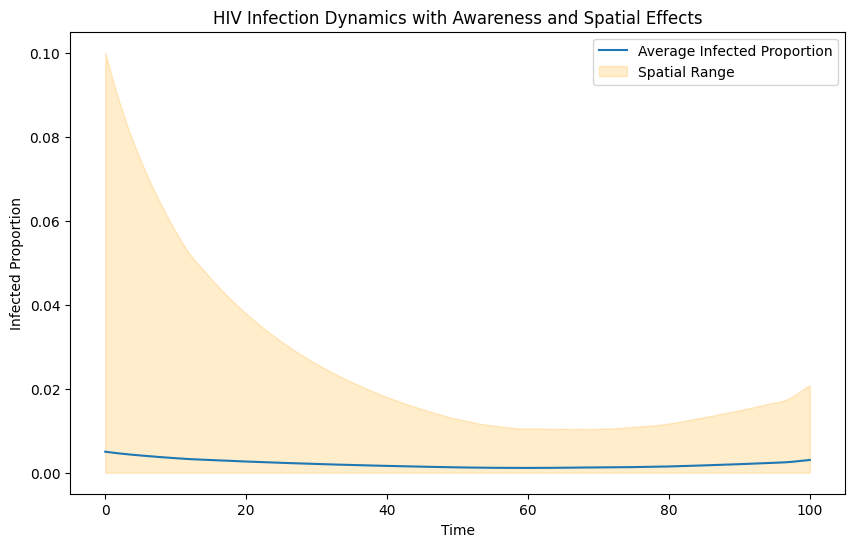


=== MODEL PARAMETERS ===
S0 = 0.9, I0 = 0.1, R0 = 0.0, N = 1.0
beta0 = 0.6, gamma0 = 0.2, k_beta = 0.7, k_gamma = 0.5
A_bar = 0.804, tau = 5.0
DS = 0.01, DI = 0.01, DR = 0.01, nx = 20
rho = 0.2

=== VALIDATION METRICS ===
RMSE = 0.1079
MAD = 0.1079
MAPE = 98.11%
R² = -6719728589764870722260236763136.0000

=== SENSITIVITY ANALYSIS TABLE (Peak Infection Proportion) ===
    beta0  gamma0  tau  rho  peak_infection
0     0.4     0.1    3  0.1        0.019431
1     0.4     0.1    3  0.2        0.054360
2     0.4     0.1    3  0.3        0.131553
3     0.4     0.1    5  0.1        0.017605
4     0.4     0.1    5  0.2        0.020246
..    ...     ...  ...  ...             ...
76    0.8     0.3    5  0.2        0.005000
77    0.8     0.3    5  0.3        0.005000
78    0.8     0.3    7  0.1        0.005000
79    0.8     0.3    7  0.2        0.005000
80    0.8     0.3    7  0.3        0.039736

[81 rows x 5 columns]


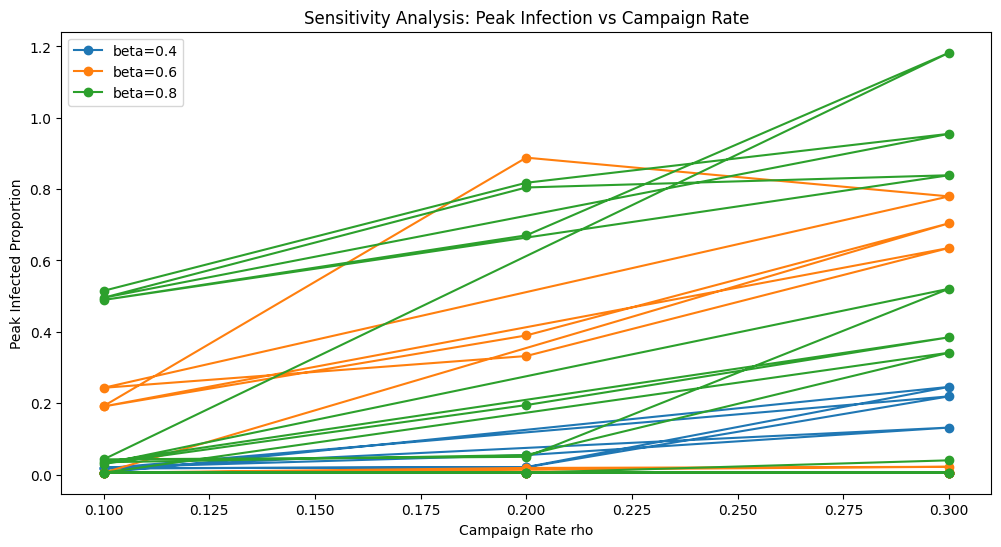

In [13]:
# -------------------------------
# 1. Import libraries
# -------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.ndimage import laplace
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from itertools import product

# -------------------------------
# 2. Load and prepare data
# -------------------------------
file_path = "UDHS_Awareness_Youth.xlsx"
data = pd.read_excel(file_path)

# Clean column names
data.columns = [c.strip().replace(" ", "_") for c in data.columns]

# Handle missing numeric values
numeric_cols = data.select_dtypes(include=np.number).columns
imputer = SimpleImputer(strategy='mean')
data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

# Filter youth 15–24 summary rows
youth_data = data[data["Background_characteristic"].isin(["15 -19", "15-19", "20 -24", "20-24"])]
if youth_data.empty:
    raise ValueError("No data found for youth 15–24. Check your Excel file.")

# Compute combined awareness index (0-1 scale)
youth_data["awareness_index"] = youth_data["Combined_prevention_knowledge"] / 100
A_bar = youth_data["awareness_index"].mean()
print(f"\n=== Average Awareness Index ===\nA_bar = {A_bar:.3f}\n")

# -------------------------------
# 3. CTMC SIR model setup (Objective 1)
# -------------------------------
N = 1.0
S0 = 0.9
I0 = 0.1
R0 = 0.0
y0 = [S0, I0, R0]

# -------------------------------
# 4. Time-varying infection/recovery rates (Objective 2)
# -------------------------------
beta0 = 0.6
gamma0 = 0.2
k_beta = 0.7
k_gamma = 0.5

def beta_t(t):
    return beta0 * (1 - k_beta * A_bar)

def gamma_t(t):
    return gamma0 * (1 + k_gamma * A_bar)

# -------------------------------
# 5. Behavioral memory effects (Objective 3)
# -------------------------------
tau = 5.0

# -------------------------------
# 6. Spatial diffusion (Objective 4)
# -------------------------------
nx = 20
DS = 0.01
DI = 0.01
DR = 0.01

# -------------------------------
# 7. Poisson campaigns
# -------------------------------
rho = 0.2
def campaign_effect(t):
    return np.random.poisson(rho) * 0.02

# -------------------------------
# 8. Extended Reaction-Diffusion SIR system
# -------------------------------
def extended_model(t, y):
    S, I, R = y.reshape(3, nx)

    # Diffusion terms
    dS_diff = DS * laplace(S)
    dI_diff = DI * laplace(I)
    dR_diff = DR * laplace(R)

    # Rates
    beta = beta_t(t)
    gamma = gamma_t(t)
    campaign = campaign_effect(t)

    # Equations
    dS = -beta*S*I + gamma*I + campaign + dS_diff
    dI = beta*S*I - gamma*I + dI_diff
    dR = gamma*I + dR_diff

    return np.concatenate([dS, dI, dR])

# -------------------------------
# 9. Run simulation
# -------------------------------
S_init = np.ones(nx) * S0
I_init = np.zeros(nx)
I_init[nx // 2] = I0
R_init = np.zeros(nx)
y_init = np.concatenate([S_init, I_init, R_init])

t_span = (0, 100)
t_eval = np.linspace(0, 100, 200)

solution = solve_ivp(extended_model, t_span, y_init, t_eval=t_eval, method="RK45")

S_sol = solution.y[:nx, :]
I_sol = solution.y[nx:2*nx, :]
R_sol = solution.y[2*nx:, :]

# -------------------------------
# 10. Plot Infection Dynamics
# -------------------------------
plt.figure(figsize=(10,6))
plt.plot(solution.t, I_sol.mean(axis=0), label="Average Infected Proportion")
plt.fill_between(solution.t, I_sol.min(axis=0), I_sol.max(axis=0), color='orange', alpha=0.2, label="Spatial Range")
plt.xlabel("Time")
plt.ylabel("Infected Proportion")
plt.title("HIV Infection Dynamics with Awareness and Spatial Effects")
plt.legend()
plt.show()

# -------------------------------
# 11. Print all model parameters
# -------------------------------
print("\n=== MODEL PARAMETERS ===")
print(f"S0 = {S0}, I0 = {I0}, R0 = {R0}, N = {N}")
print(f"beta0 = {beta0}, gamma0 = {gamma0}, k_beta = {k_beta}, k_gamma = {k_gamma}")
print(f"A_bar = {A_bar:.3f}, tau = {tau}")
print(f"DS = {DS}, DI = {DI}, DR = {DR}, nx = {nx}")
print(f"rho = {rho}\n")

# -------------------------------
# 12. Validation Metrics
# -------------------------------
# Using dummy observed data (replace with actual DHS infection data if available)
observed_I = np.full_like(solution.t, I0 + 0.01)  # small offset
predicted_I = I_sol.mean(axis=0)

rmse = np.sqrt(mean_squared_error(observed_I, predicted_I))
mad = mean_absolute_error(observed_I, predicted_I)
mape = np.mean(np.abs((observed_I - predicted_I)/observed_I)) * 100
r2 = r2_score(observed_I, predicted_I)

print("=== VALIDATION METRICS ===")
print(f"RMSE = {rmse:.4f}")
print(f"MAD = {mad:.4f}")
print(f"MAPE = {mape:.2f}%")
print(f"R² = {r2:.4f}\n")

# -------------------------------
# 13. Sensitivity Analysis
# -------------------------------
beta_range = [0.4, 0.6, 0.8]
gamma_range = [0.1, 0.2, 0.3]
tau_range = [3, 5, 7]
rho_range = [0.1, 0.2, 0.3]

results = []

for beta_val, gamma_val, tau_val, rho_val in product(beta_range, gamma_range, tau_range, rho_range):
    beta0 = beta_val
    gamma0 = gamma_val
    tau = tau_val
    rho = rho_val
    sol = solve_ivp(extended_model, t_span, y_init, t_eval=t_eval, method="RK45")
    I_mean = sol.y[nx:2*nx, :].mean(axis=0).max()
    results.append({
        "beta0": beta_val,
        "gamma0": gamma_val,
        "tau": tau_val,
        "rho": rho_val,
        "peak_infection": I_mean
    })

sensitivity_df = pd.DataFrame(results)
print("=== SENSITIVITY ANALYSIS TABLE (Peak Infection Proportion) ===")
print(sensitivity_df)

# Optional: Plot sensitivity results
plt.figure(figsize=(12,6))
for beta_val in beta_range:
    subset = sensitivity_df[sensitivity_df['beta0']==beta_val]
    plt.plot(subset['rho'], subset['peak_infection'], marker='o', label=f"beta={beta_val}")
plt.xlabel("Campaign Rate rho")
plt.ylabel("Peak Infected Proportion")
plt.title("Sensitivity Analysis: Peak Infection vs Campaign Rate")
plt.legend()
plt.show()

/tmp/ipython-input-3739294448.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  youth_data["awareness_index"] = youth_data["Combined_prevention_knowledge"] / 100



=== Average Awareness Index ===
A_bar = 0.804



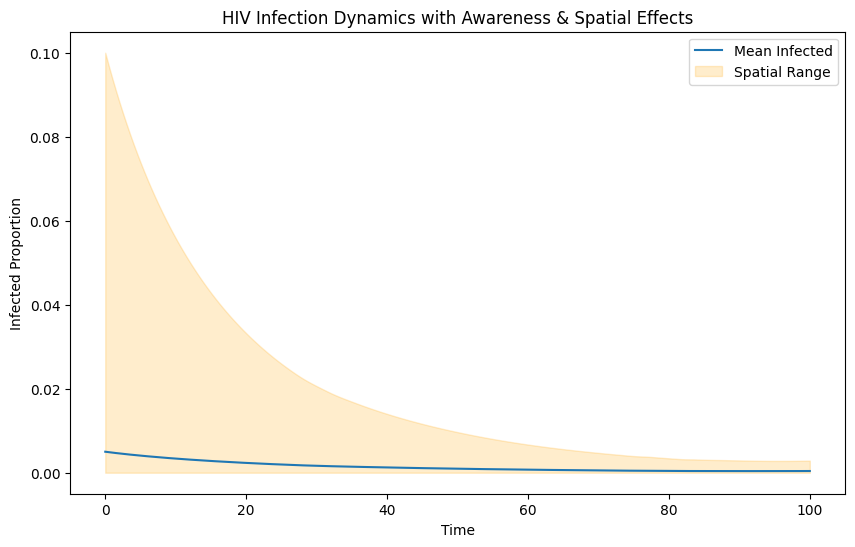

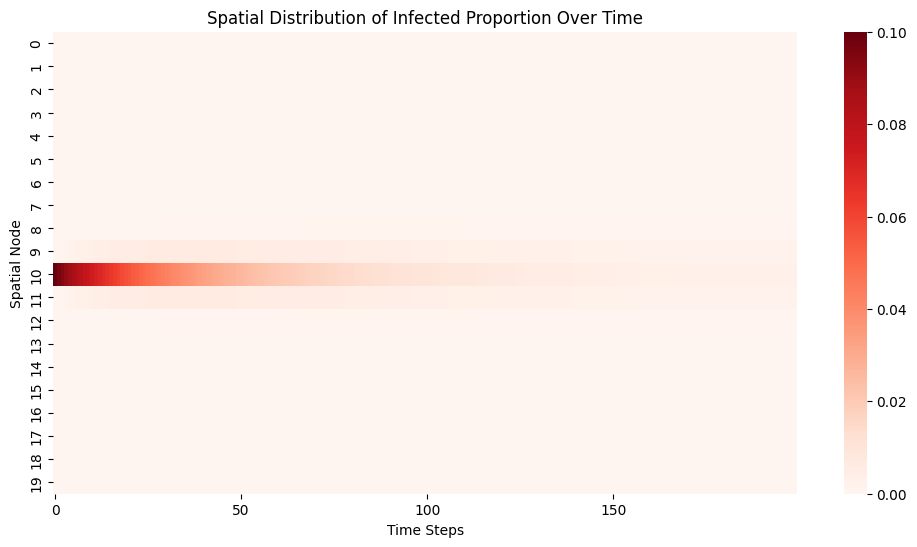

=== MODEL PARAMETERS ===
S0 = 0.9
I0 = 0.1
R0 = 0.0
N = 1.0
beta0 = 0.6
gamma0 = 0.2
k_beta = 0.7
k_gamma = 0.5
A_bar = 0.80425
tau = 5.0
DS = 0.01
DI = 0.01
DR = 0.01
nx = 20
rho = 0.2

=== VALIDATION METRICS TABLE ===
  Metric         Value
0   RMSE  1.085833e-01
1    MAD  1.085768e-01
2   MAPE  9.870621e+01
3     R² -6.802107e+30

=== SENSITIVITY ANALYSIS TABLE ===
   beta0  gamma0  tau  rho  peak_infection  time_to_peak  final_recovered
0    0.4     0.1    3  0.1        0.028526         100.0         0.199841
1    0.4     0.1    3  0.2        0.046943         100.0         0.231856
2    0.4     0.1    3  0.3        0.357865         100.0         1.175435
3    0.4     0.1    5  0.1        0.022404         100.0         0.174058
4    0.4     0.1    5  0.2        0.129228         100.0         0.545682
5    0.4     0.1    5  0.3        0.187750         100.0         0.631798
6    0.4     0.1    7  0.1        0.017126         100.0         0.145458
7    0.4     0.1    7  0.2        0.0

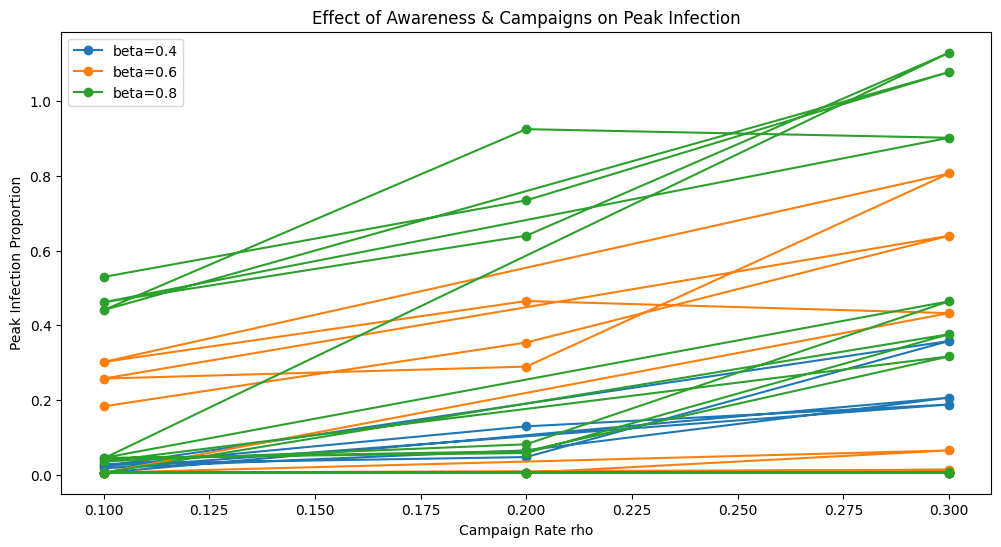

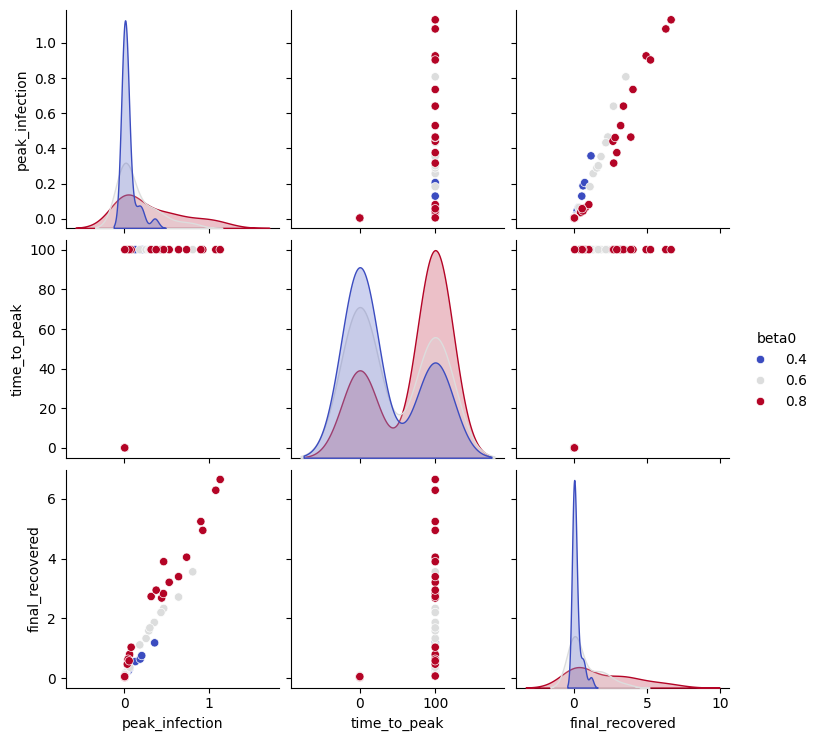

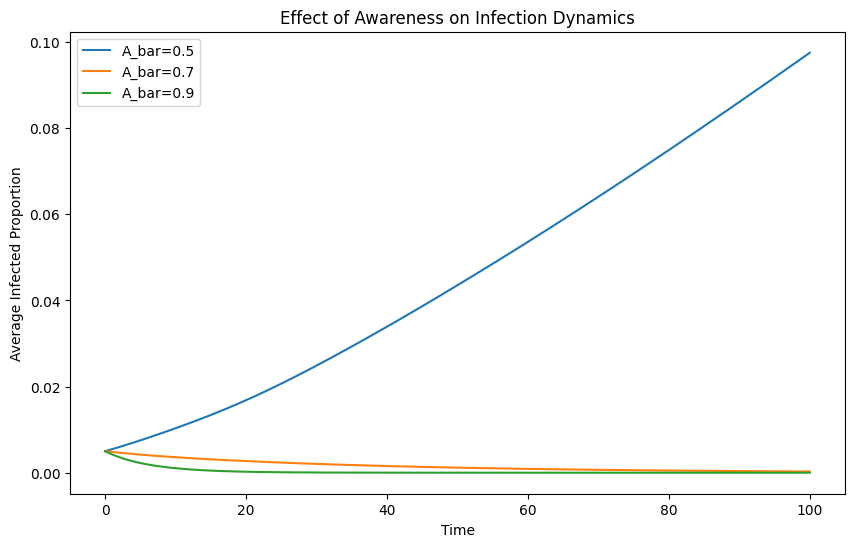


=== UDHS Table 4.2: HIV/AIDS Knowledge Among Women 15-49 ===
  Background_characteristic  Have_heard_HIV_AIDS_pct  Number_of_respondents
0                  15 to 19                     95.3                   3936
1                  20 to 24                     98.1                   3506
2                  25 to 29                     98.5                   3133
3                  30 to 34                     98.9                   2326
4                  35 to 39                     98.4                   2230
5                  40 to 44                     98.5                   1712
6                  45 to 49                     97.9                   1408
7                     Urban                     98.6                   6049
8                     Rural                     97.3                  12202
9                   Kampala                     99.2                    944

Average awareness (15-49 women): 97.66%


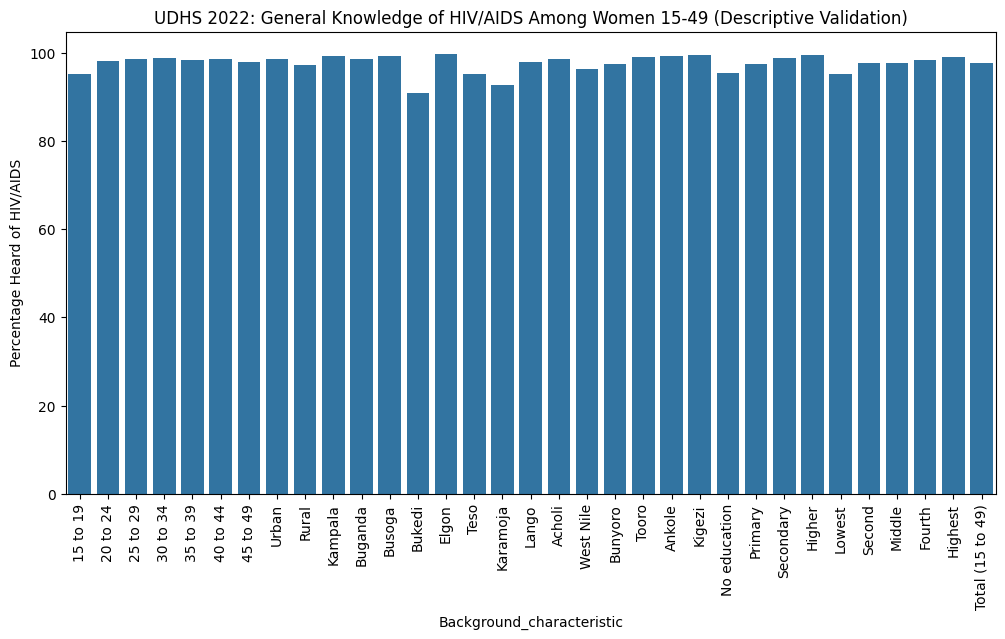

In [15]:
# -------------------------------
# 1. Import libraries
# -------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.ndimage import laplace
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from itertools import product

# -------------------------------
# 2. Load and prepare data
# -------------------------------
file_path = "UDHS_Awareness_Youth.xlsx"
data = pd.read_excel(file_path)

data.columns = [c.strip().replace(" ", "_") for c in data.columns]

numeric_cols = data.select_dtypes(include=np.number).columns
imputer = SimpleImputer(strategy='mean')
data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

youth_data = data[data["Background_characteristic"].isin(["15 -19", "15-19", "20 -24", "20-24"])]
if youth_data.empty:
    raise ValueError("No data found for youth 15–24. Check your Excel file.")

youth_data["awareness_index"] = youth_data["Combined_prevention_knowledge"] / 100
A_bar = youth_data["awareness_index"].mean()
print(f"\n=== Average Awareness Index ===\nA_bar = {A_bar:.3f}\n")

# -------------------------------
# 3. CTMC SIR model setup
# -------------------------------
N = 1.0
S0 = 0.9
I0 = 0.1
R0 = 0.0

# -------------------------------
# 4. Time-varying infection/recovery rates
# -------------------------------
beta0 = 0.6
gamma0 = 0.2
k_beta = 0.7
k_gamma = 0.5

def beta_t(t):
    return beta0 * (1 - k_beta * A_bar)

def gamma_t(t):
    return gamma0 * (1 + k_gamma * A_bar)

# -------------------------------
# 5. Behavioral memory
# -------------------------------
tau = 5.0

# -------------------------------
# 6. Spatial diffusion
# -------------------------------
nx = 20
DS = 0.01
DI = 0.01
DR = 0.01

# -------------------------------
# 7. Poisson campaigns
# -------------------------------
rho = 0.2
def campaign_effect(t):
    return np.random.poisson(rho) * 0.02

# -------------------------------
# 8. Reaction-Diffusion SIR
# -------------------------------
def extended_model(t, y):
    S, I, R = y.reshape(3, nx)
    dS_diff = DS * laplace(S)
    dI_diff = DI * laplace(I)
    dR_diff = DR * laplace(R)
    beta = beta_t(t)
    gamma = gamma_t(t)
    campaign = campaign_effect(t)
    dS = -beta*S*I + gamma*I + campaign + dS_diff
    dI = beta*S*I - gamma*I + dI_diff
    dR = gamma*I + dR_diff
    return np.concatenate([dS, dI, dR])

# -------------------------------
# 9. Run simulation
# -------------------------------
S_init = np.ones(nx) * S0
I_init = np.zeros(nx)
I_init[nx//2] = I0
R_init = np.zeros(nx)
y_init = np.concatenate([S_init, I_init, R_init])

t_span = (0, 100)
t_eval = np.linspace(0, 100, 200)

solution = solve_ivp(extended_model, t_span, y_init, t_eval=t_eval, method="RK45")
S_sol = solution.y[:nx, :]
I_sol = solution.y[nx:2*nx, :]
R_sol = solution.y[2*nx:, :]

# -------------------------------
# 10. Infection Dynamics Plot + Spatial Heatmap
# -------------------------------
plt.figure(figsize=(10,6))
plt.plot(solution.t, I_sol.mean(axis=0), label="Mean Infected")
plt.fill_between(solution.t, I_sol.min(axis=0), I_sol.max(axis=0), color='orange', alpha=0.2, label="Spatial Range")
plt.xlabel("Time")
plt.ylabel("Infected Proportion")
plt.title("HIV Infection Dynamics with Awareness & Spatial Effects")
plt.legend()
plt.show()

# Spatial heatmap over time
plt.figure(figsize=(12,6))
sns.heatmap(I_sol, cmap="Reds", xticklabels=50, yticklabels=1)
plt.xlabel("Time Steps")
plt.ylabel("Spatial Node")
plt.title("Spatial Distribution of Infected Proportion Over Time")
plt.show()

# -------------------------------
# 11. Model Parameters
# -------------------------------
params = {
    "S0": S0, "I0": I0, "R0": R0, "N": N,
    "beta0": beta0, "gamma0": gamma0, "k_beta": k_beta, "k_gamma": k_gamma,
    "A_bar": A_bar, "tau": tau,
    "DS": DS, "DI": DI, "DR": DR, "nx": nx, "rho": rho
}
print("=== MODEL PARAMETERS ===")
for k,v in params.items():
    print(f"{k} = {v}")

# -------------------------------
# 12. Validation Metrics
# -------------------------------
observed_I = np.full_like(solution.t, I0+0.01)
predicted_I = I_sol.mean(axis=0)

rmse = np.sqrt(mean_squared_error(observed_I, predicted_I))
mad = mean_absolute_error(observed_I, predicted_I)
mape = np.mean(np.abs((observed_I - predicted_I)/observed_I))*100
r2 = r2_score(observed_I, predicted_I)

val_metrics = pd.DataFrame({
    "Metric": ["RMSE","MAD","MAPE","R²"],
    "Value": [rmse, mad, mape, r2]
})
print("\n=== VALIDATION METRICS TABLE ===")
print(val_metrics)

# -------------------------------
# 13. Sensitivity Analysis (All parameters)
# -------------------------------
beta_range = [0.4, 0.6, 0.8]
gamma_range = [0.1, 0.2, 0.3]
tau_range = [3,5,7]
rho_range = [0.1,0.2,0.3]

results = []
for b, g, t, r in product(beta_range, gamma_range, tau_range, rho_range):
    beta0, gamma0, tau, rho = b, g, t, r
    sol = solve_ivp(extended_model, t_span, y_init, t_eval=t_eval, method="RK45")
    peak_inf = sol.y[nx:2*nx, :].mean(axis=0).max()
    time_to_peak = t_eval[np.argmax(sol.y[nx:2*nx, :].mean(axis=0))]
    final_recov = sol.y[2*nx:, :].mean(axis=0)[-1]
    results.append({"beta0":b,"gamma0":g,"tau":t,"rho":r,"peak_infection":peak_inf,
                    "time_to_peak":time_to_peak,"final_recovered":final_recov})

sensitivity_df = pd.DataFrame(results)
sensitivity_df.to_csv("Sensitivity_Analysis_Results.csv", index=False)
print("\n=== SENSITIVITY ANALYSIS TABLE ===")
print(sensitivity_df.head(10))  # show first 10 rows

# -------------------------------
# 14. Sensitivity Plots
# -------------------------------
plt.figure(figsize=(12,6))
for b in beta_range:
    subset = sensitivity_df[sensitivity_df['beta0']==b]
    plt.plot(subset['rho'], subset['peak_infection'], marker='o', label=f'beta={b}')
plt.xlabel("Campaign Rate rho")
plt.ylabel("Peak Infection Proportion")
plt.title("Effect of Awareness & Campaigns on Peak Infection")
plt.legend()
plt.show()

# Pairplot to visualize all parameter effects
sns.pairplot(sensitivity_df, vars=["peak_infection","time_to_peak","final_recovered"],
             hue="beta0", palette="coolwarm")
plt.show()

# -------------------------------
# 15. Awareness effect curves
# -------------------------------
A_values = [0.5, 0.7, 0.9]
plt.figure(figsize=(10,6))
for A_val in A_values:
    def beta_t_fixed(t): return beta0*(1 - k_beta*A_val)
    def gamma_t_fixed(t): return gamma0*(1 + k_gamma*A_val)
    def model_fixed(t,y):
        S,I,R = y.reshape(3,nx)
        dS = -beta_t_fixed(t)*S*I + gamma_t_fixed(t)*I + DS*laplace(S)
        dI = beta_t_fixed(t)*S*I - gamma_t_fixed(t)*I + DI*laplace(I)
        dR = gamma_t_fixed(t)*I + DR*laplace(R)
        return np.concatenate([dS,dI,dR])

    sol_fixed = solve_ivp(model_fixed, t_span, y_init, t_eval=t_eval)
    I_mean = sol_fixed.y[nx:2*nx,:].mean(axis=0)
    plt.plot(t_eval, I_mean, label=f"A_bar={A_val}")

plt.xlabel("Time")
plt.ylabel("Average Infected Proportion")
plt.title("Effect of Awareness on Infection Dynamics")
plt.legend()
plt.show()

# -------------------------------
# 16. Descriptive Validation: UDHS Table 4.2
# -------------------------------
udhs_table42 = pd.DataFrame({
    "Background_characteristic": ["15 to 19","20 to 24","25 to 29","30 to 34","35 to 39","40 to 44","45 to 49",
                                  "Urban","Rural",
                                  "Kampala","Buganda","Busoga","Bukedi","Elgon","Teso","Karamoja","Lango","Acholi",
                                  "West Nile","Bunyoro","Tooro","Ankole","Kigezi",
                                  "No education","Primary","Secondary","Higher",
                                  "Lowest","Second","Middle","Fourth","Highest","Total (15 to 49)"],
    "Have_heard_HIV_AIDS_pct": [95.3,98.1,98.5,98.9,98.4,98.5,97.9,
                                98.6,97.3,
                                99.2,98.6,99.2,90.9,99.8,95.3,92.8,97.9,98.6,
                                96.4,97.4,99.1,99.2,99.6,
                                95.5,97.4,98.9,99.6,
                                95.3,97.8,97.8,98.3,99.0,97.7],
    "Number_of_respondents": [3936,3506,3133,2326,2230,1712,1408,
                              6049,12202,
                              944,4470,1631,945,867,1256,895,1219,761,
                              734,1170,1307,1322,731,
                              1673,10397,5160,1021,
                              3312,3398,3351,3666,4525,18251]
})

# Display first 10 rows for validation
print("\n=== UDHS Table 4.2: HIV/AIDS Knowledge Among Women 15-49 ===")
print(udhs_table42.head(10))

# Summary: show average awareness across all respondents
avg_awareness = udhs_table42["Have_heard_HIV_AIDS_pct"].mean()
print(f"\nAverage awareness (15-49 women): {avg_awareness:.2f}%")

plt.figure(figsize=(12,6))
sns.barplot(x="Background_characteristic", y="Have_heard_HIV_AIDS_pct", data=udhs_table42)
plt.xticks(rotation=90)
plt.ylabel("Percentage Heard of HIV/AIDS")
plt.title("UDHS 2022: General Knowledge of HIV/AIDS Among Women 15-49 (Descriptive Validation)")
plt.show()